## Paquetes

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from dateutil import relativedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

## Datasets

In [6]:
datasets_path = "//home/francisco/Documents/Practica/Time-Series-Library/datasets/"

In [7]:
coffee_df  = pd.read_csv(datasets_path+ 'Coffee_500Exog.csv')
coffee_results_df=  pd.read_csv(datasets_path+ 'Coffee_500Exog_results.csv')
sugar_df  = pd.read_csv(datasets_path+ 'Sugar_500Exog.csv')
sugar_results_df =  pd.read_csv(datasets_path+ 'Sugar_500Exog_results.csv')


## Funciones utiles

In [8]:
coffee_df_plot = sugar_df
coffee_df_plot['date'] = pd.to_datetime(coffee_df_plot['date'])
coffee_df_plot =coffee_df_plot.set_index('date')

In [9]:
def load_squeeze(path):
    pred = np.load(path+'pred.npy')
    true = np.load(path+'true.npy')
    dates = np.load(path+'dates.npy')
    preds = np.squeeze(pred)
    trues = np.squeeze(true)
    dates = np.squeeze(dates)
    return dates,trues,preds

In [10]:
def load_squeeze_M(path):
    pred = np.load(path+'pred.npy')
    true = np.load(path+'true.npy')
    dates = np.load(path+'dates.npy')
    preds = np.squeeze(pred)
    trues = np.squeeze(true)
    dates = np.squeeze(dates)
    return dates,trues,preds

In [11]:
def create_df_stack(n,d,dates,trues,preds,df,model_name,xrnn=None):
    #Dataframe predicciones
    date_s = pd.Series(dates[0])
    date = pd.to_datetime(date_s, format='%Y%m%d')
    true_df = pd.DataFrame(trues[0])
    pred_df = pd.DataFrame(preds[0])
    date_df = date.to_frame()
    times_df = pd.concat([date_df,true_df,pred_df],axis=1)

    times_df.columns = ['date', 'true', model_name ]
    times_df.set_index('date',inplace=True)

        

    for i in range(1,n):
        date_s = pd.Series(dates[d*i])
        date = pd.to_datetime(date_s, format='%Y%m%d')
        
        pred_df = pd.DataFrame(preds[d*i])
        date_df = date.to_frame()
        times_df_n = pd.concat([date_df,pred_df],axis=1)

        times_df_n.columns = ['date', f'Times{d*i}' ]
        times_df_n.set_index('date',inplace=True)
        times_df = times_df.merge(times_df_n,on='date',how='outer')

        
    ## Dataframe xrn
    if xrnn is not None:
   
        xrnn = xrnn.iloc[:,[0,3]]
        xrnn.set_index('date',inplace=True)
        xrnn.index = pd.to_datetime(xrnn.index)
        xrnn.columns = ['Xrnn']
        ## Dataframe timesnet + xrnn
        total_df = times_df.join(xrnn,on='date')
        
    ## Dataframe contexto
    context = df.iloc[:,[0,2]]
    context.set_index('date',inplace=True)
    context.index = pd.to_datetime(context.index)
    ## Dataframe timesnet + xrnn + contexto
    if xrnn is not None:
        with_context =context.join(total_df, on='date')
        return with_context,total_df
    else:
        with_context = context.join(times_df, on='date')
        return with_context,times_df

In [12]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [13]:
def calc_metrics(y_actual, y_predicted):
    MSE = truncate(mean_squared_error(y_actual, y_predicted),2)
    RMSE = truncate(math.sqrt(MSE),2)
    MAE = truncate(mean_absolute_error(y_actual, y_predicted),2)
    MAPE = truncate(mean_absolute_percentage_error(y_actual, y_predicted),2)
    print("MSE: {} ---RMSE: {} ---MAE: {} ---MAPE: {}".format(MSE, RMSE, MAE, MAPE))
    return MSE, RMSE, MAE, MAPE

In [14]:
def graficar(virtual_present,path,path_dlinear, df,result_df=None,N=0,D=0):
    resultados = '/home/francisco/Documents/Practica/Time-Series-Library/'
    path_resultados = resultados + path + '/'

    virtual_present= datetime.strptime(virtual_present, "%Y-%m-%d")
    test_start= virtual_present - relativedelta.relativedelta(weeks=52)
    
    date,true,pred = load_squeeze(path_resultados)

    date_dl, true_dl , pred_dl = load_squeeze(path_dlinear)
    
    result_wc,result_woc = create_df_stack(N,D,date,true,pred,df,'TimesNet',result_df)

    results_wc_dl, results_woc_dl = create_df_stack(N,D,date_dl,true_dl,pred_dl,df,'DLinear')

    w_context = result_wc.merge(results_woc_dl, on='date',how='outer')

    wo_context = w_context.merge(results_woc_dl, on='date')

    w_context = w_context[w_context.index>test_start]
    
    wo_context = wo_context[wo_context.index>test_start]

    timesnet_metrics = calc_metrics(true[N],pred[N])
    dl_metrics = calc_metrics(true_dl[N],pred_dl[N])
    xrnn_metrics = []
    if result_df is not None:
        xrnn_values =  result_df['units'].to_numpy()
        xrnn_metrics = calc_metrics(true[N],xrnn_values)
        
    
    return w_context,wo_context ,timesnet_metrics,dl_metrics, xrnn_metrics

# Resultados Cafe

## Original

- Resultados obtenidos al utilizar el dataset de cafe para entrenamiento y el dataset de cafe para pruebas.

- TimesNet Train Time = 267.68 seconds

- DLinear Train Time = 11.52 seconds

In [66]:
path_timesnet = 'results/Timesnet_test_cafe_PV:2021-12-13__TimesNet_Coffee_500Exog.csv_sl52_ll26_pl52/'
path_dlinear = 'results/DLinear_test_cafe_PV:2021-12-13__DLinear_Coffee_500Exog.csv_sl52_ll26_pl52/'
vp = '2021-12-13'

In [67]:
wc , woc ,tn_metrics,dlinear_metrics, xrnn_metrics= graficar(vp,path_timesnet,path_dlinear,coffee_df,coffee_results_df,N=0,D=0)

MSE: 4207.12 ---RMSE: 64.86 ---MAE: 61.11 ---MAPE: 0.27
MSE: 4051.36 ---RMSE: 63.65 ---MAE: 59.51 ---MAPE: 0.26
MSE: 429.19 ---RMSE: 20.71 ---MAE: 14.36 ---MAPE: 0.07


In [68]:
mse,rms,mae,mape = tn_metrics


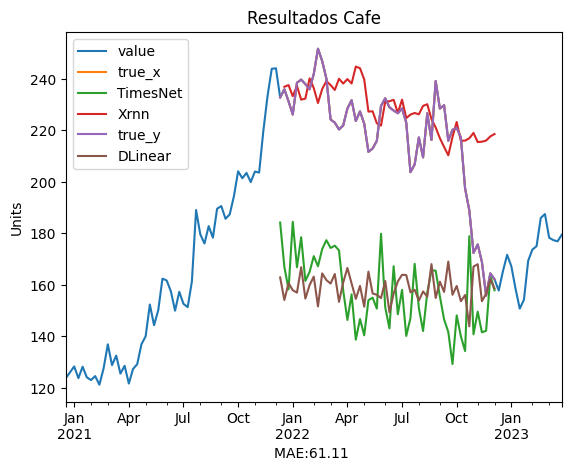

In [69]:
ax = wc.plot(title='Resultados Cafe',ylabel = 'Units' , xlabel = f'MAE:{mae} ')
